In [ ]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-69pz41zy
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-69pz41zy
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 94e20ea7e510ac4d665492b8bed8836a5143f16e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

Mean Absolute Error (MAE) on normalized data: 0.0855
Mean Absolute Error (MAE) on original scale: 0.8427


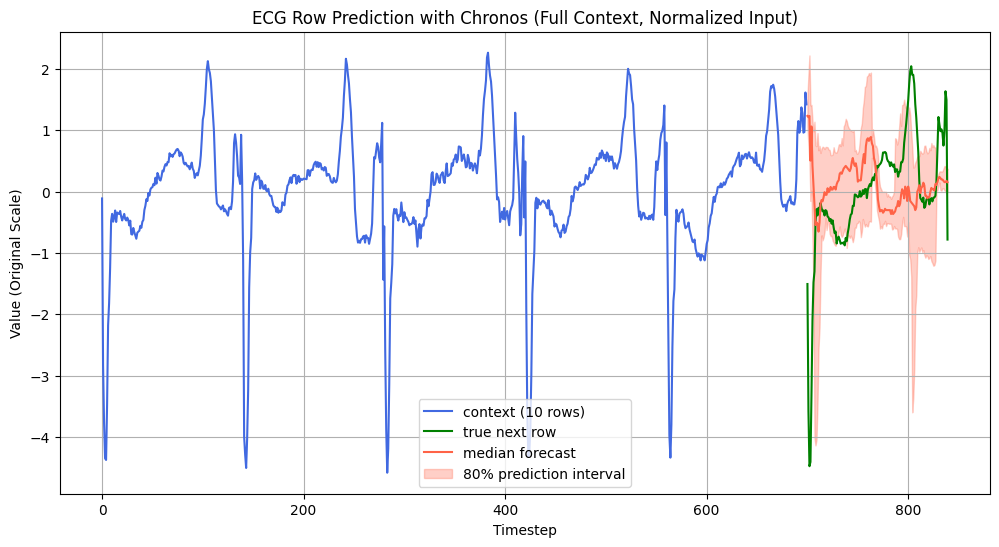

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from chronos import ChronosPipeline

# Initialize the Chronos pipeline
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

# Read the data from the file
with open("ECG5000_TRAIN.txt", "r") as file:
    data_string = file.read()

# Parse the data into a list of rows
lines = data_string.strip().split("\n")
time_series_data = []
for line in lines:
    if line.strip():  # Skip empty lines
        values = [float(x) for x in line.split()]
        # Exclude the first value (label), take the next 140 timesteps
        time_series_data.append(values[1:141])  # Slice to get 140 timesteps

# Convert to numpy array for easier manipulation
time_series_data = np.array(time_series_data)

# Normalize the data to [0, 1] range
data_min = time_series_data.min()
data_max = time_series_data.max()
normalized_data = (time_series_data - data_min) / (data_max - data_min)

# Number of rows to use as context (e.g., 10 previous rows)
n_context_rows = 5
context_length = n_context_rows * 140  # 10 rows * 140 timesteps = 1400 timesteps
prediction_length = 140  # Predict the next full row (140 timesteps)

# Use the first 10 rows as context to predict the 11th row
context_data = normalized_data[:n_context_rows].flatten()  # Flatten into a 1D array (1400 timesteps)
true_next_row = normalized_data[n_context_rows]  # The actual 11th row (140 timesteps)

# Convert context to a 1D tensor
context = torch.tensor(context_data, dtype=torch.float16)

# Generate forecast for the next 140 timesteps
forecast = pipeline.predict(context, prediction_length)  # shape [1, num_samples, 140]

# Extract forecast statistics
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

# Calculate Mean Absolute Error (MAE) on normalized data
mae = np.mean(np.abs(median - true_next_row))
print(f"Mean Absolute Error (MAE) on normalized data: {mae:.4f}")

# Optional: Denormalize the forecast for visualization and comparison on original scale
denorm_median = median * (data_max - data_min) + data_min
denorm_low = low * (data_max - data_min) + data_min
denorm_high = high * (data_max - data_min) + data_min
denorm_true_next_row = true_next_row * (data_max - data_min) + data_min
denorm_context_data = context_data * (data_max - data_min) + data_min

# Calculate MAE on denormalized (original) scale
mae_denorm = np.mean(np.abs(denorm_median - denorm_true_next_row))
print(f"Mean Absolute Error (MAE) on original scale: {mae_denorm:.4f}")

# Visualize the full context, true next row, and forecast (on original scale)
plt.figure(figsize=(12, 6))

# Plot the full context (all 1400 timesteps)
plt.plot(range(0, context_length), denorm_context_data,
         color="royalblue", label="context (10 rows)")

# Plot the true next row
plt.plot(range(context_length, context_length + 140), denorm_true_next_row,
         color="green", label="true next row")

# Plot the forecast
forecast_index = range(context_length, context_length + prediction_length)
plt.plot(forecast_index, denorm_median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, denorm_low, denorm_high, color="tomato", alpha=0.3, label="80% prediction interval")

plt.legend()
plt.grid()
plt.title("ECG Row Prediction with Chronos (Full Context, Normalized Input)")
plt.xlabel("Timestep")
plt.ylabel("Value (Original Scale)")
plt.show()